# Twin4Build: Parameter Estimation Example

Welcome to this tutorial on using the Twin4Build package! In this notebook, you'll learn how to:
1. Setup the environment

Let's get started!

## 1. Setup
First, let's install and import the necessary packages:

In [1]:
#%pip install git+https://github.com/JBjoernskov/Twin4Build.git # Uncomment in google colab
import sys
import twin4build as tb
import datetime
from dateutil import tz
import twin4build.utils.plot.plot as plot

## 2. Creating the Model

In this example, we will use the one_room_example_model.xlsm file. 
This file contains a model of a single room with a space heater and supply and return ventilation.
We use the translation engine to automatically create the components and connections.

In [2]:
import twin4build.examples.utils as utils
# Create a new model
model = tb.Model(id="mymodel")
filename = utils.get_path(["parameter_estimation_example", "one_room_example_model.xlsm"])
model.load(semantic_model_filename=filename)


C:\Users\jabj\Documents\python\Twin4Build\twin4build\utils\mkdir_in_root.py:5: MainPathNotFound: Could not determine main module path, using temp dir: C:\Users\jabj\AppData\Local\Temp\1
  current_dir = get_main_dir()



Loading model...
   |___Reading semantic model...[OK]
   |___Drawing input object graph...[OK]
   |___Parsing semantic model...[OK]
   |___Drawing parsed object graph...[OK]
   |___Connecting components...[OK]
   |___Drawing system graph...[OK]
   |___Removing cycles...[OK]
   |___Drawing system graph without cycles...[OK]
   |___Determining execution order...[OK]
   |___Creating execution graph...[OK]
   |___Drawing execution graph...[OK]
   |___Loading parameters...[OK]
   |___Validating model...[WARNING]
   |   |
   |   |___|CLASS: BuildingSpace0AdjBoundaryOutdoorFMUSystem|ID: [020B][020B_space_heater]|: Missing values for the following parameter(s) to enable use of Simulator, Evaluator, and Monitor:
   |   |   |
   |   |   |___C_supply
   |   |   |___C_wall
   |   |   |___C_air
   |   |   |___C_boundary
   |   |   |___R_out
   |   |   |___R_in
   |   |   |___R_boundary
   |   |   |___f_wall
   |   |   |___f_air
   |   |   |___Q_occ_gain
   |   |   |___CO2_occ_gain
   |   |   |___C

From the model validation above we see that different types of information is missing. 
As we are focusing on parameter estimation in this example, we will add the missing information that is relevant to this task.
Here, the "[020B][020B_space_heater]" component is missing an input "supplyWaterTemperature".
In addition, some filenames are missing for the sensors and some of the schedules need to be defined.
Let's add the missing information and validate again.


In [3]:
def fcn(self):
    supply_water_schedule = tb.ScheduleSystem(
    weekDayRulesetDict = {
        "ruleset_default_value": 60,
        "ruleset_start_minute": [],
        "ruleset_end_minute": [],
        "ruleset_start_hour": [],
        "ruleset_end_hour": [],
        "ruleset_value": []
    },
    id="supply_water_schedule"
    )
    self.add_connection(supply_water_schedule, self.component_dict["[020B][020B_space_heater]"], "scheduleValue", "supplyWaterTemperature") # Add missing input
    self.component_dict["020B_temperature_sensor"].filename = utils.get_path(["parameter_estimation_example", "temperature_sensor.csv"])
    self.component_dict["020B_co2_sensor"].filename = utils.get_path(["parameter_estimation_example", "co2_sensor.csv"])
    self.component_dict["020B_valve_position_sensor"].filename = utils.get_path(["parameter_estimation_example", "valve_position_sensor.csv"])
    self.component_dict["020B_damper_position_sensor"].filename = utils.get_path(["parameter_estimation_example", "damper_position_sensor.csv"])
    self.component_dict["BTA004"].filename = utils.get_path(["parameter_estimation_example", "supply_air_temperature.csv"])
    self.component_dict["020B_co2_setpoint"].weekDayRulesetDict = {"ruleset_default_value": 900,
                                                                    "ruleset_start_minute": [],
                                                                    "ruleset_end_minute": [],
                                                                    "ruleset_start_hour": [],
                                                                    "ruleset_end_hour": [],
                                                                    "ruleset_value": []}
    self.component_dict["020B_temperature_heating_setpoint"].useFile = True
    self.component_dict["020B_temperature_heating_setpoint"].filename = utils.get_path(["parameter_estimation_example", "temperature_heating_setpoint.csv"])
    self.component_dict["outdoor_environment"].filename = utils.get_path(["parameter_estimation_example", "outdoor_environment.csv"])


model.load(semantic_model_filename=filename, fcn=fcn, verbose=False)


Loading model...
   |___Reading semantic model...[OK]
   |___Drawing input object graph...[OK]
   |___Parsing semantic model...[OK]
   |___Drawing parsed object graph...[OK]
   |___Connecting components...[OK]
   |___Applying user defined function...[OK]
   |___Drawing system graph...[OK]
   |___Removing cycles...[OK]
   |___Drawing system graph without cycles...[OK]
   |___Determining execution order...[OK]
   |___Creating execution graph...[OK]
   |___Drawing execution graph...[OK]
   |___Loading parameters...[OK]
   |___Validating model...[WARNING]
   |   |
   |   |___|CLASS: BuildingSpace0AdjBoundaryOutdoorFMUSystem|ID: [020B][020B_space_heater]|: Missing values for the following parameter(s) to enable use of Simulator, Evaluator, and Monitor:
   |   |   |
   |   |   |___C_supply
   |   |   |___C_wall
   |   |   |___C_air
   |   |   |___C_boundary
   |   |   |___R_out
   |   |   |___R_in
   |   |   |___R_boundary
   |   |   |___f_wall
   |   |   |___f_air
   |   |   |___Q_occ_gain

As shown above, the validation of the model for Estimation now passes.

### Visualizing the Model (not required)
We can visualize the model to see the components and connections.<br>
This is not required, but it can be helpful for debugging and for building the model.<br>
The nodes in the graph represent components, and the edges represent connections between components as defined earlier.

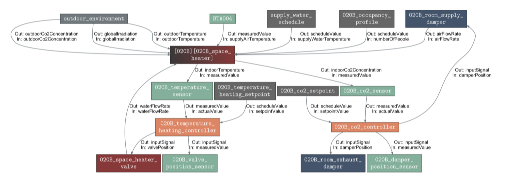

In [4]:
import matplotlib.pyplot as plt
import os
system_graph = os.path.join(model.graph_path, "system_graph.png")
image = plt.imread(system_graph)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.axis('off')
plt.show()

## 3. Setting up parameter estimation

Now that our model is set up, let's set up the parameter estimation.
We will use the LS estimation method to estimate the parameters.
The LS estimation method is a data-driven method that finds the parameters that minimize the error between the simulation results and the measurement results.




   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0886e+06                                    2.56e+06    
       1              2         8.7507e+05      2.14e+05       6.30e-03       1.97e+06    
       2              3         3.8403e+05      4.91e+05       1.56e-02       4.86e+09    
       3              4         2.5537e+05      1.29e+05       2.11e-04       2.91e+08    
       4              5         2.5364e+05      1.73e+03       6.02e-05       1.33e+06    
       5              6         7.1218e+04      1.82e+05       6.75e-03       3.29e+08    
       6              7         6.8957e+04      2.26e+03       3.54e-05       6.89e+07    
       7              8         6.8856e+04      1.01e+02       8.88e-06       3.98e+06    
       8              9         6.8743e+04      1.13e+02       1.13e+02       2.71e+06    
       9             10         6.8655e+04      8.78e+01       8.85e+01       2.71e+06    

100%|██████████| 1440/1440 [00:01<00:00, 722.86it/s]


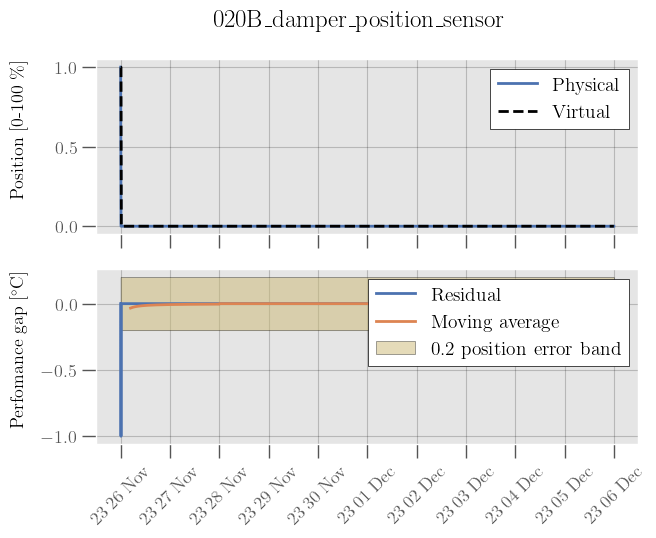

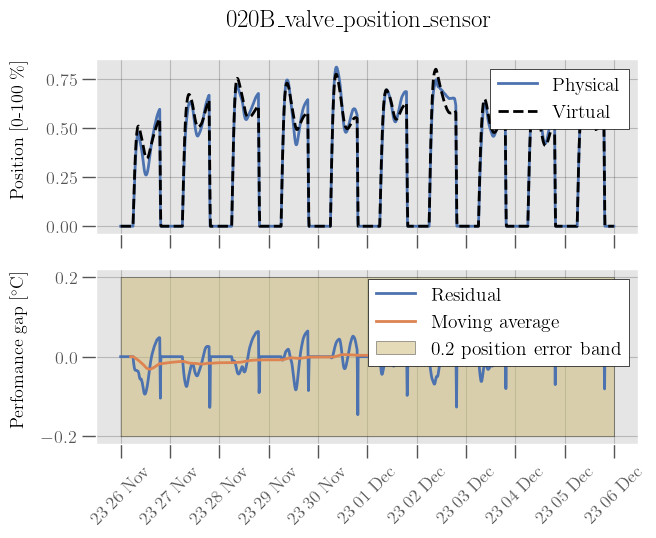

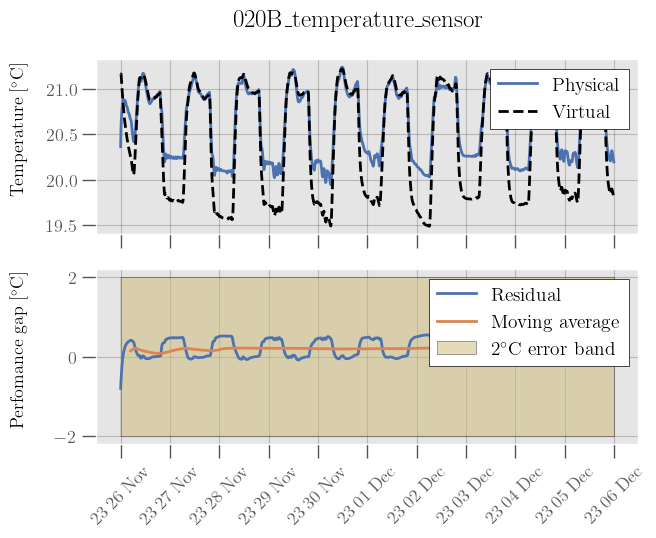

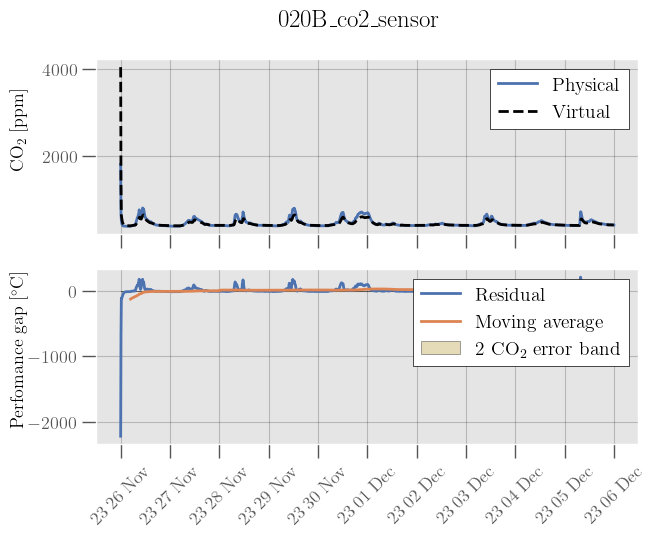

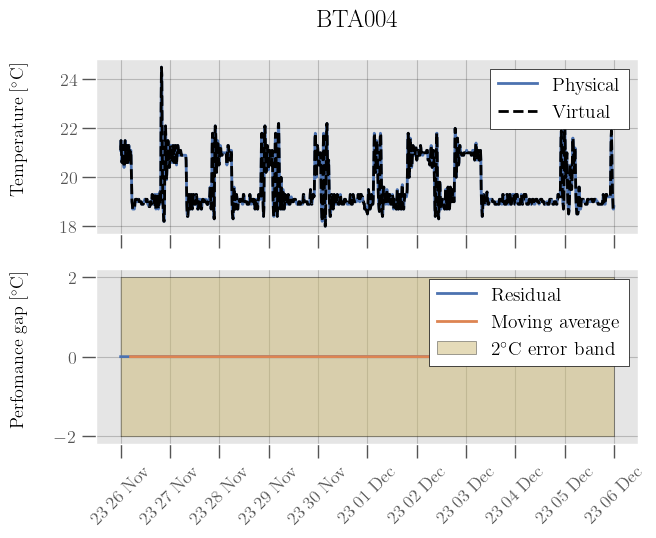

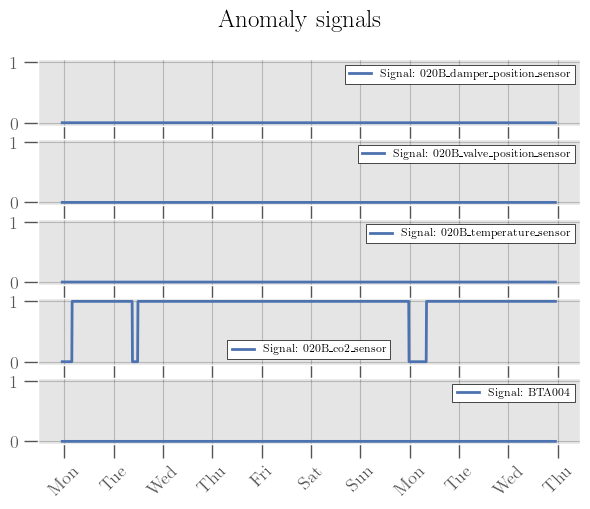

In [5]:
from dateutil.tz import gettz 
stepSize = 600  # Seconds
startTime = datetime.datetime(year=2023, month=11, day=27, hour=0, minute=0, second=0,
                                tzinfo=gettz("Europe/Copenhagen"))
endTime = datetime.datetime(year=2023, month=12, day=7, hour=0, minute=0, second=0,
                            tzinfo=gettz("Europe/Copenhagen"))
space = model.component_dict["[020B][020B_space_heater]"]
heating_controller = model.component_dict["020B_temperature_heating_controller"]
co2_controller = model.component_dict["020B_co2_controller"]
space_heater_valve = model.component_dict["020B_space_heater_valve"]
supply_damper = model.component_dict["020B_room_supply_damper"]
exhaust_damper = model.component_dict["020B_room_exhaust_damper"]

space.CO2_start = 400
space.fraRad_sh = 0.35
space.T_a_nominal_sh = 333.15
space.T_b_nominal_sh = 303.15
space.TAir_nominal_sh = 293.15


targetParameters = {"private": {"C_wall": {"components": [space], "x0": 1.7e+6, "lb": 1e+6, "ub": 2e+6}, #1.5e+6
                                "C_air": {"components": [space], "x0": 1.7e+6, "lb": 1e+4, "ub": 2e+6}, #3e+6
                                "C_boundary": {"components": [space], "x0": 2e+4, "lb": 1e+4, "ub": 2e+5}, #1e+5
                                "R_out": {"components": [space], "x0": 0.014, "lb": 1e-3, "ub": 0.5}, #0.2
                                "R_in": {"components": [space], "x0": 0.024, "lb": 1e-3, "ub": 0.5}, #0.2
                                "R_boundary": {"components": [space], "x0": 0.001, "lb": 9.9e-4, "ub": 0.3}, #0.005
                                "f_wall": {"components": [space], "x0": 0.5, "lb": 0, "ub": 2}, #1
                                "f_air": {"components": [space], "x0": 0.5, "lb": 0, "ub": 2}, #1
                                "kp": {"components": [heating_controller, co2_controller], "x0": 1e-3, "lb": 1e-6, "ub": 3}, #1e-3
                                "Ti": {"components": [heating_controller, co2_controller], "x0": 5, "lb": 1e-5, "ub": 10}, #3
                                "m_flow_nominal": {"components": [space_heater_valve], "x0": 0.0202, "lb": 1e-3, "ub": 0.5}, #0.0202
                                "dpFixed_nominal": {"components": [space_heater_valve], "x0": 1, "lb": 0, "ub": 10000}, #2000
                                "T_boundary": {"components": [space], "x0": 21, "lb": 19, "ub": 24}, #20
                                "a": {"components": [supply_damper, exhaust_damper], "x0": 5, "lb": 0.5, "ub": 8}, #2
                                "infiltration": {"components": [space], "x0": 0.001, "lb": 1e-4, "ub": 0.3}, #0.001
                                "Q_occ_gain": {"components": [space], "x0": 50, "lb": 10, "ub": 1000}, #100,
                                "C_supply": {"components": [space], "x0": 400, "lb": 100, "ub": 600}, #400
                                "Q_flow_nominal_sh": {"components": [space], "x0": 500, "lb": 10, "ub": 1000}, #100,
                                "n_sh": {"components": [space], "x0": 1.24, "lb": 1, "ub": 2}, #1
                                "CO2_occ_gain": {"components": [space], "x0": 8.18e-6, "lb": 1e-8, "ub": 1e-4}, #100,
                                }}


percentile = 2
targetMeasuringDevices = {model.component_dict["020B_valve_position_sensor"]: {"standardDeviation": 0.01/percentile, "scale_factor": 1},
                            model.component_dict["020B_temperature_sensor"]: {"standardDeviation": 0.1/percentile, "scale_factor": 20},
                            model.component_dict["020B_co2_sensor"]: {"standardDeviation": 10/percentile, "scale_factor": 400},
                            model.component_dict["020B_damper_position_sensor"]: {"standardDeviation": 0.01/percentile, "scale_factor": 1},
                            }

# Options for the MCMC estimation method. If the options argument is not supplied or None is supplied, default options are applied.  
options = {"n_sample": 20, #500 #This is a test file, and we therefore only sample 2. Typically, we need at least 1000 samples before the chain converges. 
            "n_temperature": 1, #20 #Number of parallel chains/temperatures.
            "fac_walker": 8, #Scaling factor for the number of ensemble walkers per chain. This number is multiplied with the number of estimated to get the number of ensemble walkers per chain. Minimum is 2 (required by PTEMCEE).
            "prior": "uniform", #Prior distribution - "gaussian" is also implemented
            "walker_initialization": "gaussian", #Initialization of parameters - "gaussian" is also implemented
            "add_gp": False,
            "n_cores":6,
            "n_save_checkpoint": 1
            }
estimator = tb.Estimator(model)
estimator.estimate(targetParameters=targetParameters,
                    targetMeasuringDevices=targetMeasuringDevices,
                    startTime=startTime,
                    endTime=endTime,
                    stepSize=stepSize,
                    n_initialization_steps=288,
                    method="LS", #Use Least Squares instead
                    options=options
                    )
model.load_estimation_result(estimator.result_savedir_pickle)

print("SOLUTION")
print("C_wall: ", space.C_wall)
print("C_air: ", space.C_air)
print("C_boundary: ", space.C_boundary)
print("R_out: ", space.R_out)
print("R_in: ", space.R_in)
print("R_boundary: ", space.R_boundary)
print("f_wall: ", space.f_wall)
print("f_air: ", space.f_air)
print("Q_occ_gain: ", space.Q_occ_gain)
print("kp: ", heating_controller.kp)
print("Ti: ", heating_controller.Ti)
print("m_flow_nominal: ", space_heater_valve.m_flow_nominal)
print("dpFixed_nominal: ", space_heater_valve.dpFixed_nominal)
print("T_boundary: ", space.T_boundary)
print("a: ", supply_damper.a)
print("a: ", exhaust_damper.a)
print("infiltration: ", space.infiltration)
print("CO2_occ_gain: ", space.CO2_occ_gain)
print("Q_flow_nominal_sh: ", space.Q_flow_nominal_sh)
print("n_sh: ", space.n_sh)
print("C_supply: ", space.C_supply)

monitor = tb.Monitor(model) #Compares the simulation results with the expected results
monitor.monitor(startTime=startTime,
                    endTime=endTime,
                    stepSize=stepSize,
                    show=True)




## Visualizing the Results

Finally, let's visualize the results of our simulation.

## Conclusion

Congratulations! You've successfully created a simple Twin4Build model, simulated it, and visualized the results. 

In this tutorial, you learned how to:
1. Create a model and add components (schedule and damper)
2. Connect components in the model
3. Set up and run a simulation
4. Visualize the simulation results

Next steps:
- Try adding more components to create more complex models
- Experiment with different schedules and parameter values
- Explore other visualization options in the `plot` module

For more advanced usage and detailed documentation, please refer to the Twin4Build documentation.